In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
color_pal=sns.color_palette()

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Market Size', 'Marketing Expense'],axis=1)

In [4]:
sales_b.head()

,Year,Sales,Month No.
Month-Year,,,
2019-01-01,2019,494357,1
2019-02-01,2019,837207,2
2019-03-01,2019,1278271,3
2019-04-01,2019,675985,4
2019-05-01,2019,757687,5


<Axes: title={'center': 'Product B'}, xlabel='Month-Year'>

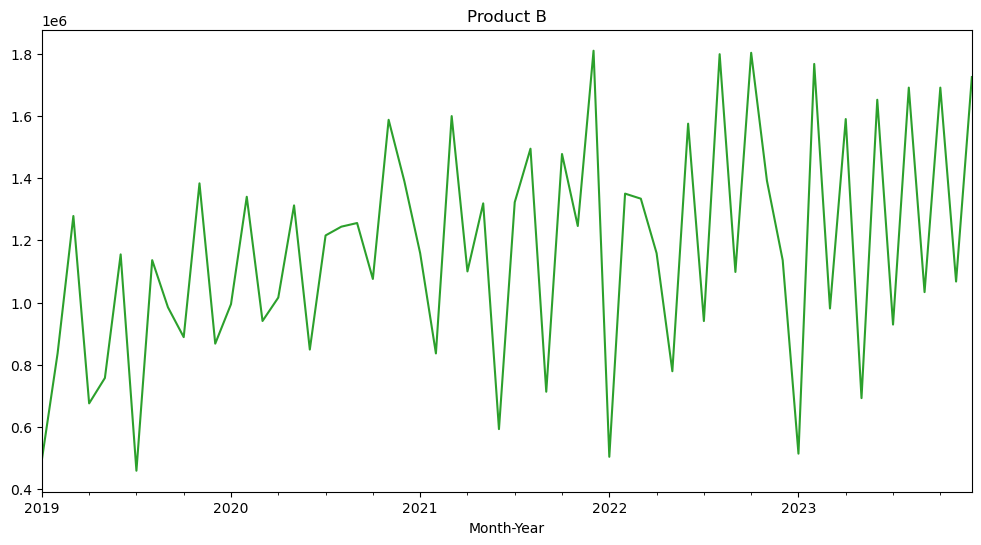

In [5]:
sales_b['Sales'].plot(figsize=(12,6),color=color_pal[2],title='Product B')

<Axes: ylabel='Frequency'>

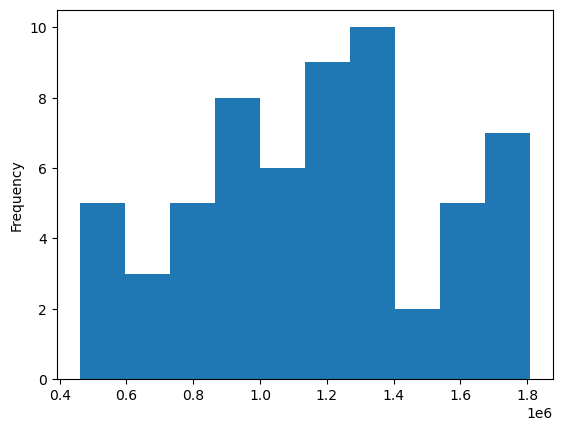

In [6]:
sales_b['Sales'].plot(kind='hist')

# Visualization

In [7]:
sales_b.head()

,Year,Sales,Month No.
Month-Year,,,
2019-01-01,2019,494357,1
2019-02-01,2019,837207,2
2019-03-01,2019,1278271,3
2019-04-01,2019,675985,4
2019-05-01,2019,757687,5


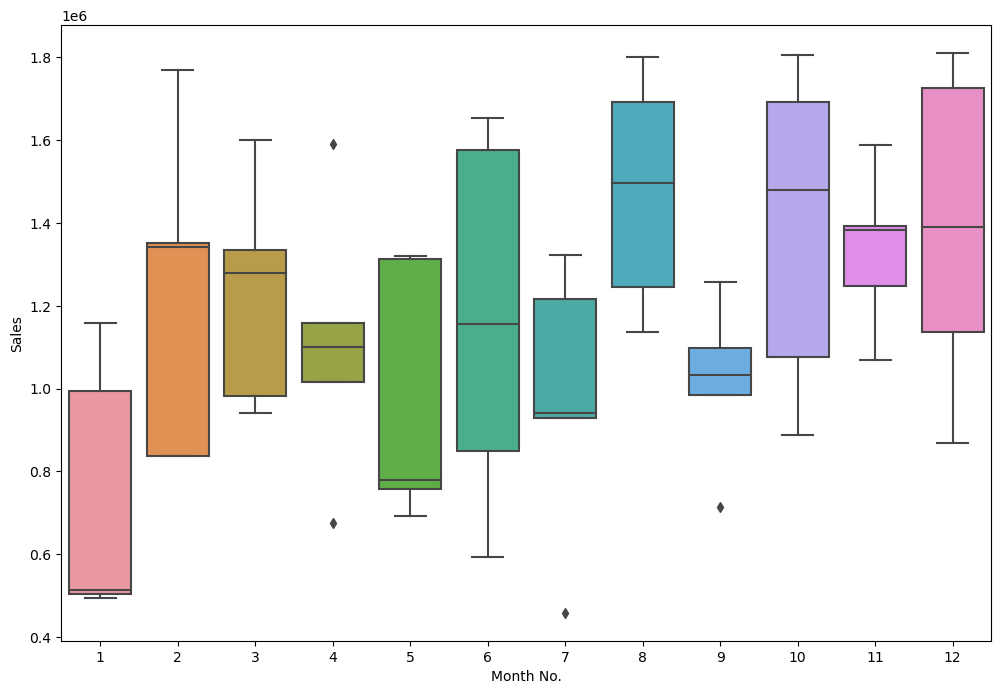

In [8]:
plt.figure(figsize=(12,8))
sns.boxplot(data=sales_b, x='Month No.',y='Sales')
plt.show()

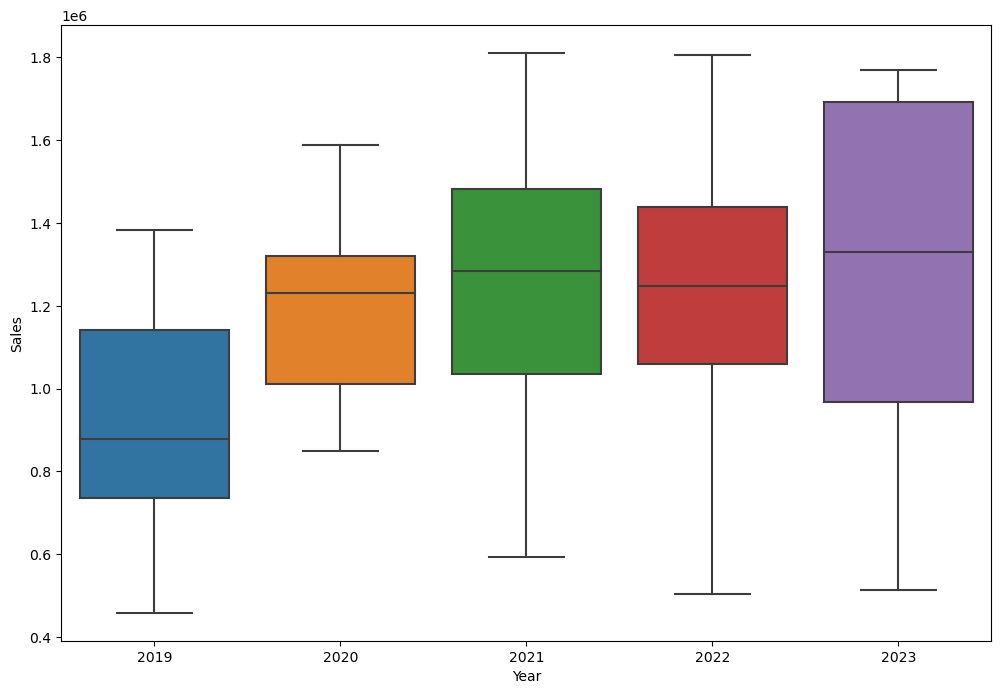

In [9]:
plt.figure(figsize=(12,8))
sns.boxplot(data=sales_b, x='Year',y='Sales')
plt.show()

# Feature Engineering

In [10]:
sales_b= df.drop(['Product Name','Product Category','Month','Market Size', 'Marketing Expense','Month No.','Year'],axis=1)

In [11]:
sales_b['quarter'] = sales_b.index.quarter
sales_b['month'] = sales_b.index.month
sales_b['year'] = sales_b.index.year

In [12]:
# Create lagged values
#lagged_intervals = [1, 3, 6, 12]  # Lagged intervals in months
#for lag in lagged_intervals:
#    sales_b[f'sales_lag_{lag}'] = sales_b['Sales'].shift(lag)

In [13]:
print(sales_b)

              Sales  quarter  month  year
Month-Year                               
2019-01-01   494357        1      1  2019
2019-02-01   837207        1      2  2019
2019-03-01  1278271        1      3  2019
2019-04-01   675985        2      4  2019
2019-05-01   757687        2      5  2019
2019-06-01  1154891        2      6  2019
2019-07-01   459535        3      7  2019
2019-08-01  1136386        3      8  2019
2019-09-01   984890        3      9  2019
2019-10-01   888942        4     10  2019
2019-11-01  1383258        4     11  2019
2019-12-01   867962        4     12  2019
2020-01-01   994941        1      1  2020
2020-02-01  1340112        1      2  2020
2020-03-01   940807        1      3  2020
2020-04-01  1016144        2      4  2020
2020-05-01  1312370        2      5  2020
2020-06-01   848998        2      6  2020
2020-07-01  1215806        3      7  2020
2020-08-01  1243995        3      8  2020
2020-09-01  1255719        3      9  2020
2020-10-01  1075916        4     1

# Train/Test Split

In [14]:
train= sales_b[:48]
test=sales_b[48:]

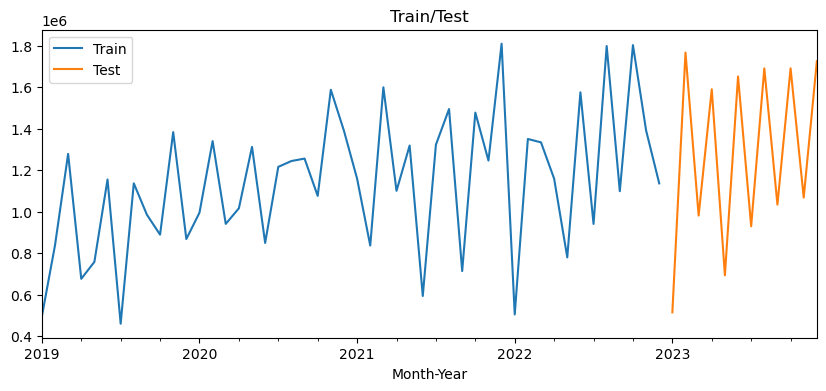

In [15]:
fig,ax=plt.subplots(figsize=(10,4))
train['Sales'].plot(ax=ax,label='Train set',title='Train/Test')
test['Sales'].plot(ax=ax,label='Test set')
plt.legend(['Train','Test'])
plt.show()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2019-01-01 to 2022-12-01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Sales    48 non-null     int64
 1   quarter  48 non-null     int64
 2   month    48 non-null     int64
 3   year     48 non-null     int64
dtypes: int64(4)
memory usage: 1.9 KB


In [17]:
#x_train=train[['Month No.','Year','Quarter', 'sales_lag_1', 'sales_lag_3', 'sales_lag_6','sales_lag_12','MA_3','MA_6','MA_12']]
#y_train=train['Sales']
#x_test=test[['Month No.','Year','stationary_target','MA_3','MA_6','MA_12']]
#y_test=test['Sales']

In [18]:
x_train = train.drop(columns=['Sales'])
y_train=train['Sales']
x_test=test.drop(columns=['Sales'])
y_test=test['Sales']

In [19]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 2000],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# Instantiate the XGBoost regressor
regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Access the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best estimator:", best_estimator)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Best estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [19]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       objective='reg:squarederror',
                       max_depth=3,
                       colsample_bytree=0.7,
                       subsample= 0.8,
                       early_stopping_rounds=50,
                       learning_rate=0.001)

reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1186792.11768	validation_1-rmse:1348393.26359
[100]	validation_0-rmse:1086365.35556	validation_1-rmse:1247515.94195
[200]	validation_0-rmse:995533.91037	validation_1-rmse:1155590.76796
[300]	validation_0-rmse:913477.44458	validation_1-rmse:1072371.73511
[400]	validation_0-rmse:839972.34890	validation_1-rmse:997494.15060
[500]	validation_0-rmse:773661.03220	validation_1-rmse:930029.81292
[600]	validation_0-rmse:714270.19601	validation_1-rmse:869724.39000
[700]	validation_0-rmse:660831.21445	validation_1-rmse:815413.99341
[800]	validation_0-rmse:612870.10153	validation_1-rmse:766741.27774
[900]	validation_0-rmse:570314.75528	validation_1-rmse:723691.28553
[1000]	validation_0-rmse:531828.07059	validation_1-rmse:684471.80017
[1100]	validation_0-rmse:497908.93906	validation_1-rmse:649829.47466
[1200]	validation_0-rmse:467629.59771	validation_1-rmse:618608.51757
[1300]	validation_0-rmse:440751.42230	validation_1-rmse:591204.17998
[1400]	validation_0-rmse:416946.26133	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
reg.best_iteration

1999

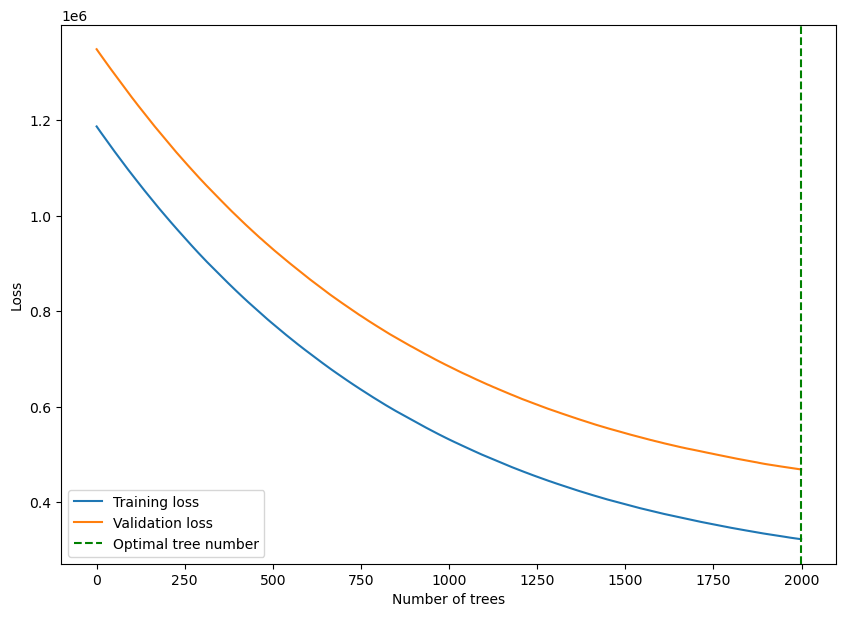

In [21]:
results = reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(1999,color='green',ls='--', label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

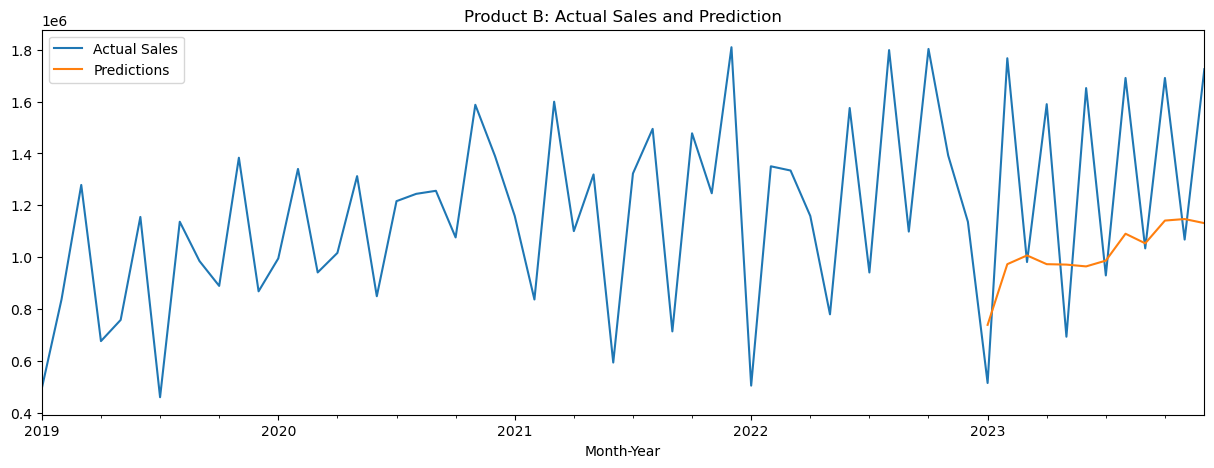

In [22]:
pred=reg.predict(x_test)
sales_b['prediction']=[None]*len(train) + list(pred)

ax = sales_b['Sales'].plot(figsize=(15, 5))
sales_b['prediction'].plot()
plt.legend(['Actual Sales', 'Predictions'])
ax.set_title('Product B: Actual Sales and Prediction')
plt.show()

In [23]:
mae_xgb= mean_absolute_error(test['Sales'],pred)
mse_xgb=mean_squared_error(test['Sales'], pred)
mape_xgb= mean_absolute_percentage_error(test['Sales'],pred)
rmse_xgb= np.sqrt(mean_squared_error(test['Sales'],pred))

print(f'MAE - XGBoost: {mae_xgb:0.3f}')
print(f'MAPE - XGBoost: {mape_xgb:0.3f}')
print(f'MSE - XGBoost: {mse_xgb:0.3f}')
print(f'RMSE - XGBoost: {rmse_xgb:0.3f}')

MAE - XGBoost: 377306.891
MAPE - XGBoost: 0.275
MSE - XGBoost: 219949429260.039
RMSE - XGBoost: 468987.664


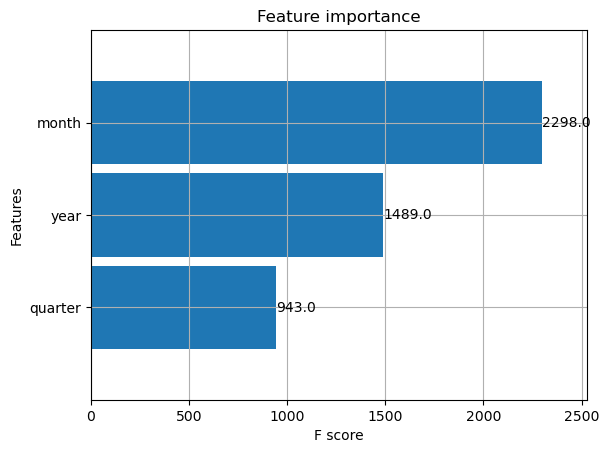

In [24]:
from xgboost import plot_importance

_ = plot_importance(reg, height=0.9)

# FORECASTING

In [25]:
x = sales_b.drop(columns=['Sales','prediction'])
y = sales_b['Sales']

In [26]:
reg_forecast= xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       objective='reg:squarederror',
                       max_depth=3,
                       colsample_bytree=0.7,
                       subsample= 0.8,
                       learning_rate=0.001)

reg_forecast.fit(x, y,
        eval_set=[(x, y)],
        verbose=100)

[0]	validation_0-rmse:1220769.97359
[100]	validation_0-rmse:1117395.88849
[200]	validation_0-rmse:1023914.21947
[300]	validation_0-rmse:939658.01493
[400]	validation_0-rmse:864228.40475
[500]	validation_0-rmse:796075.47879
[600]	validation_0-rmse:735146.52633
[700]	validation_0-rmse:680507.57019
[800]	validation_0-rmse:632043.65057
[900]	validation_0-rmse:588590.89006
[1000]	validation_0-rmse:549647.47073
[1100]	validation_0-rmse:515375.00421
[1200]	validation_0-rmse:484943.95941
[1300]	validation_0-rmse:457741.47749
[1400]	validation_0-rmse:433914.78294
[1500]	validation_0-rmse:413056.56289
[1600]	validation_0-rmse:394892.48113
[1700]	validation_0-rmse:378673.94657
[1800]	validation_0-rmse:364281.67445
[1900]	validation_0-rmse:351574.58544
[1999]	validation_0-rmse:340631.24786


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
future = pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
sales_b['isFuture'] = False
sales_b_and_future = pd.concat([sales_b, future_df])

In [28]:
sales_b_and_future['quarter'] = sales_b_and_future.index.quarter
sales_b_and_future['month'] = sales_b_and_future.index.month
sales_b_and_future['year'] = sales_b_and_future.index.year

In [29]:
sales_b_and_future=sales_b_and_future.drop(columns=['prediction'])

In [30]:
future_w_features = sales_b_and_future.query('isFuture').copy()
future_w_features=future_w_features.drop(columns=['Sales','isFuture'])

In [31]:
future_w_features

,quarter,month,year
2024-01-01,1,1,2024
2024-02-01,1,2,2024
2024-03-01,1,3,2024
2024-04-01,2,4,2024
2024-05-01,2,5,2024
2024-06-01,2,6,2024
2024-07-01,3,7,2024
2024-08-01,3,8,2024
2024-09-01,3,9,2024
2024-10-01,4,10,2024


In [32]:
future_w_features['pred'] = reg_forecast.predict(future_w_features)

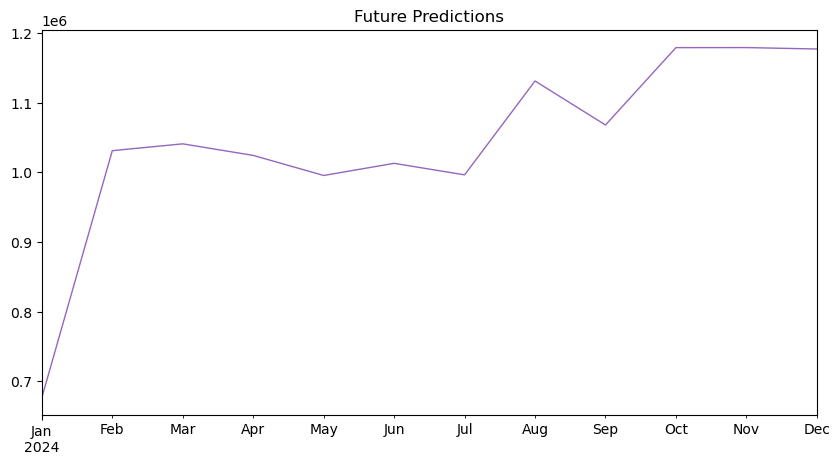

In [33]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

Text(0.5, 1.0, 'Product B')

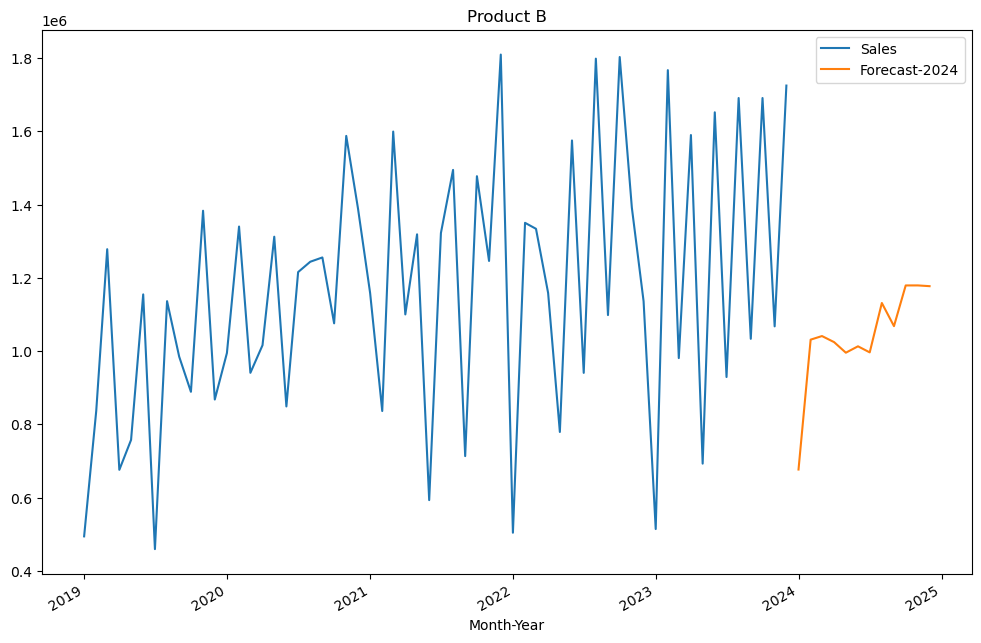

In [34]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
future_w_features['pred'].plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [154]:
# Create an empty DataFrame to store future data
future_data = pd.DataFrame(index=pd.date_range(start='2024-01-01', periods=12, freq='MS'))

# Loop through the last 12 rows of main_data
for i in range(12):
    # Extract lagged values for the current row
    lagged_values = sales_b[['sales_lag_1', 'sales_lag_3', 'sales_lag_6','sales_lag_12']].iloc[-(i + 1)]
    
    # Add the lagged values to future_data
    future_data.loc[future_data.index[i], ['sales_lag_1', 'sales_lag_3', 'sales_lag_6','sales_lag_12']] = lagged_values.values

# Display the future_data DataFrame
print(future_data)

            sales_lag_1  sales_lag_3  sales_lag_6  sales_lag_12
2024-01-01    1067615.0    1033615.0    1651940.0     1136218.0
2024-02-01    1690948.0    1690948.0     692905.0     1391774.0
2024-03-01    1033615.0     929333.0    1589911.0     1802885.0
2024-04-01    1690948.0    1651940.0     981026.0     1098441.0
2024-05-01     929333.0     692905.0    1767039.0     1798441.0
2024-06-01    1651940.0    1589911.0     514369.0      940648.0
2024-07-01     692905.0     981026.0    1136218.0     1575105.0
2024-08-01    1589911.0    1767039.0    1391774.0      779318.0
2024-09-01     981026.0     514369.0    1802885.0     1158736.0
2024-10-01    1767039.0    1136218.0    1098441.0     1333941.0
2024-11-01     514369.0    1391774.0    1798441.0     1350240.0
2024-12-01    1136218.0    1802885.0     940648.0      504283.0


In [156]:
# Create an empty DataFrame to store future data
future_data = pd.DataFrame(index=pd.date_range(start='2024-01-01', periods=12, freq='MS'))

# Loop through the last 12 rows of main_data
for i in range(12):
    # Extract lagged values for the current row
    lagged_values = sales_b[['sales_lag_1', 'sales_lag_3', 'sales_lag_6','sales_lag_12']].iloc[-(i+1)]
    
    # Add the lagged values to future_data
    future_data.loc[future_data.index[i], ['sales_lag_1', 'sales_lag_3', 'sales_lag_6','sales_lag_12']] = lagged_values.values

# Display the future_data DataFrame
print(future_data)

            sales_lag_1  sales_lag_3  sales_lag_6  sales_lag_12
2024-01-01    1067615.0    1033615.0    1651940.0     1136218.0
2024-02-01    1690948.0    1690948.0     692905.0     1391774.0
2024-03-01    1033615.0     929333.0    1589911.0     1802885.0
2024-04-01    1690948.0    1651940.0     981026.0     1098441.0
2024-05-01     929333.0     692905.0    1767039.0     1798441.0
2024-06-01    1651940.0    1589911.0     514369.0      940648.0
2024-07-01     692905.0     981026.0    1136218.0     1575105.0
2024-08-01    1589911.0    1767039.0    1391774.0      779318.0
2024-09-01     981026.0     514369.0    1802885.0     1158736.0
2024-10-01    1767039.0    1136218.0    1098441.0     1333941.0
2024-11-01     514369.0    1391774.0    1798441.0     1350240.0
2024-12-01    1136218.0    1802885.0     940648.0      504283.0


In [113]:
sales_b

,Sales,quarter,month,year,sales_lag_1,sales_lag_3,sales_lag_6,sales_lag_12,prediction,isFuture
Month-Year,,,,,,,,,,
2019-01-01,494357,1,1,2019,NaN,NaN,NaN,NaN,NaN,False
2019-02-01,837207,1,2,2019,494357.0,NaN,NaN,NaN,NaN,False
2019-03-01,1278271,1,3,2019,837207.0,NaN,NaN,NaN,NaN,False
2019-04-01,675985,2,4,2019,1278271.0,494357.0,NaN,NaN,NaN,False
2019-05-01,757687,2,5,2019,675985.0,837207.0,NaN,NaN,NaN,False
2019-06-01,1154891,2,6,2019,757687.0,1278271.0,NaN,NaN,NaN,False
2019-07-01,459535,3,7,2019,1154891.0,675985.0,494357.0,NaN,NaN,False
2019-08-01,1136386,3,8,2019,459535.0,757687.0,837207.0,NaN,NaN,False
2019-09-01,984890,3,9,2019,1136386.0,1154891.0,1278271.0,NaN,NaN,False
